In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
pitches = pd.read_csv("2024pitches.csv")
pitch_clusters = pd.read_csv("pitch_clusters.csv")
pd.set_option('display.max_columns', None)
pitches.head()


,Unnamed: 0,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
0,0,1669,NaN,2024-03-16,NaN,NaN,NaN,"Jackson, Gabriel",687637,682791,single,hit_into_play,NaN,NaN,NaN,NaN,NaN,Dylan Beavers singles on a soft ground ball to...,S,L,R,BAL,BOS,X,1.0,ground_ball,1,0,2024,NaN,NaN,NaN,NaN,682983.0,642021.0,NaN,2,9,Bot,118.13,186.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,747948,656627,694359,642197,656388,686765,681468,694812,676628,NaN,NaN,NaN,0.9,NaN,1.0,0.0,NaN,75,2,NaN,4,4,4,4,4,5,5,4,NaN,NaN,NaN,0.370,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.630,0.630,22,22,23,23,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1736,NaN,2024-03-16,NaN,NaN,NaN,"Jackson, Gabriel",687637,682791,NaN,ball,NaN,NaN,NaN,NaN,NaN,Dylan Beavers singles on a soft ground ball to...,S,L,R,BAL,BOS,B,NaN,NaN,0,0,2024,NaN,NaN,NaN,NaN,682983.0,NaN,642021.0,2,9,Bot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,747948,656627,694359,642197,656388,686765,681468,694812,676628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,1,NaN,4,4,4,4,4,4,4,4,NaN,NaN,NaN,-0.005,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.635,0.635,22,22,23,23,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1880,NaN,2024-03-16,NaN,NaN,NaN,"Jackson, Gabriel",642021,682791,walk,ball,NaN,NaN,NaN,NaN,NaN,Errol Robinson walks.,S,R,R,BAL,BOS,B,NaN,NaN,3,0,2024,NaN,NaN,NaN,NaN,682983.0,NaN,NaN,2,9,Bot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,747948,656627,694359,642197,656388,686765,681468,694812,676628,NaN,NaN,NaN,0.7,NaN,0.0,0.0,NaN,74,4,NaN,4,4,4,4,4,4,4,4,NaN,NaN,NaN,0.007,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.628,0.628,22,29,23,30,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2002,NaN,2024-03-16,NaN,NaN,NaN,"Jackson, Gabriel",642021,682791,NaN,ball,NaN,NaN,NaN,NaN,NaN,Errol Robinson walks.,S,R,R,BAL,BOS,B,NaN,NaN,2,0,2024,NaN,NaN,NaN,NaN,682983.0,NaN,NaN,2,9,Bot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,747948,656627,694359,642197,656388,686765,681468,694812,676628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74,3,NaN,4,4,4,4,4,4,4,4,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.628,0.628,22,29,23,30,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2156,NaN,2024-03-16,NaN,NaN,NaN,"Jackson, Gabriel",642021,682791,NaN,ball,NaN,NaN,NaN,NaN,NaN,Errol Robinson walks.,S,R,R,BAL,BOS,B,NaN,NaN,1,0,2024,NaN,NaN,NaN,NaN,682983.0,NaN,NaN,2,9,Bot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,747948,656627,694359,642197,656388,686765,681468,694812,676628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74,2,NaN,4,4,4,4,4,4,4,4,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.628

In [3]:
columns = [
    "pitch_type", "release_speed", "release_pos_x", "release_pos_z", "batter", "pitcher", "events", "description", "zone",
    "des", "game_type", "stand", "p_throws", "type", "balls", "strikes", "pfx_x", "pfx_z", "plate_x", "plate_z", "on_3b",
    "on_2b", "on_1b", "hc_x", "hc_y", "sv_id", "vx0", "vy0", "vz0", "ax", "ay", "az", "sz_top", "sz_bot", "hit_distance_sc",
    "launch_speed", "launch_angle", "effective_speed", "release_spin_rate", "release_extension", "game_pk", "release_pos_y",
    "estimated_woba_using_speedangle", "launch_speed_angle", "at_bat_number", "pitch_number", "pitch_name", "home_score",
    "away_score", "spin_axis", "delta_home_win_exp", "delta_run_exp", "bat_speed", "swing_length",
    "estimated_slg_using_speedangle", "delta_pitcher_run_exp", "bat_win_exp", "n_thruorder_pitcher",
    "n_priorpa_thisgame_player_at_bat", "arm_angle"
]
pitch_data = pitches[columns]
pitch_data = pitch_data.dropna(subset=['pitch_type', 'release_speed', 'spin_axis', 'release_extension', 'effective_speed'])

pitch_clusters_long = pitch_clusters.melt(id_vars=['pitcher'], var_name='pitch_type', value_name='cluster_label')
pitch_clusters_long = pitch_clusters_long[pitch_clusters_long['cluster_label'] != -1]
pitch_data = pitch_data.merge(pitch_clusters_long, on=['pitcher', 'pitch_type'], how='left')

x_bins = np.linspace(-2, 2, num=5)  
z_bins = np.linspace(0, 4, num=5)   

pitch_data["zone_x"] = np.digitize(pitch_data["plate_x"], bins=x_bins, right=False)
pitch_data["zone_z"] = np.digitize(pitch_data["plate_z"], bins=z_bins, right=False)
pitch_data["zone"] = pitch_data["zone_x"].astype(str) + "-" + pitch_data["zone_z"].astype(str)

pitch_data_bip = pitch_data[pitch_data["description"] == "hit_into_play"].copy()

features = ["launch_angle", "launch_speed"]
target = "estimated_woba_using_speedangle"
pitch_data_bip = pitch_data_bip.dropna(subset=features + [target])


For this update, I wanted to instead look at the most common launch angle and exit velocity combinations by zone. I use KNN with launch angle and exit velocity, using xwOBA as the target. I think it may be better not to look at hitter success by pitch type AND zone, since in a season, there are many data points for each bucket, so instead, I look at the most common exit velocities and launch angles by zone for the hitters. Using this data with K-Nearest Neighbors, I add a column that describes what the KNN regression predicts the xwOBA to be for a pitch in each of the zones on the hitter level.

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pitch_data_bip[features])

knn = KNeighborsRegressor(n_neighbors=10, weights="distance")
knn.fit(X_scaled, pitch_data_bip[target])

pitch_data_bip["xwOBA_KNN"] = knn.predict(X_scaled)

zone_success = pitch_data_bip.groupby(["batter", "zone_x", "zone_z"])["xwOBA_KNN"].mean().reset_index()

pitch_data = pitch_data.drop(columns=["estimated_woba_using_speedangle_zone_avg"], errors="ignore")
pitch_data = pitch_data.merge(zone_success, on=["batter", "zone_x", "zone_z"], how="left")
pitch_data.rename(columns={"xwOBA_KNN": "estimated_woba_using_speedangle_zone_avg"}, inplace=True)


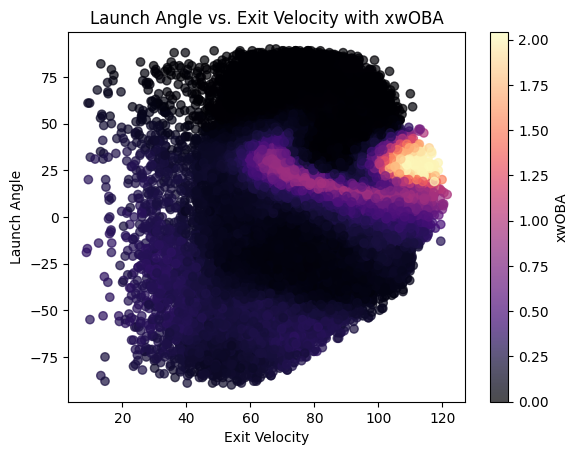

In [12]:
#plot to help visualize the K-Nearest Neighbors

pitch_data_bip = pitch_data[pitch_data["description"] == "hit_into_play"].copy()
pitch_data_bip = pitch_data_bip.dropna(subset=["launch_angle", "launch_speed"])
plt.scatter(pitch_data_bip["launch_speed"], pitch_data_bip["launch_angle"], 
            c=pitch_data_bip["estimated_woba_using_speedangle"], cmap="magma", alpha=0.7)
plt.colorbar(label="xwOBA")
plt.xlabel("Exit Velocity")
plt.ylabel("Launch Angle")
plt.title("Launch Angle vs. Exit Velocity with xwOBA")
plt.show()

In [11]:
pitch_data.sample(10)

,pitch_type,release_speed,release_pos_x,release_pos_z,batter,pitcher,events,description,zone,des,game_type,stand,p_throws,type,balls,strikes,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,hc_x,hc_y,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,release_pos_y,estimated_woba_using_speedangle,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,bat_win_exp,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,arm_angle,cluster_label,zone_x,zone_z,estimated_woba_using_speedangle_zone_avg
208234,FF,93.0,-1.95,6.40,668930,571945,NaN,ball,4-3,"Brice Turang grounds out softly, pitcher Miles...",R,L,R,B,1,1,-0.16,1.34,1.57,2.35,NaN,NaN,NaN,NaN,NaN,NaN,9.346935,-135.044904,-7.553109,-3.852045,27.794707,-14.325763,3.25,1.49,NaN,NaN,NaN,93.1,2242.0,6.4,745990,54.14,NaN,NaN,6,3,4-Seam Fastball,0,0,225.0,0.000,0.048,NaN,NaN,NaN,-0.048,0.547,1,0,43.0,0.0,4,3,0.673000
114514,ST,80.1,-1.80,5.69,455117,605513,NaN,swinging_strike,4-2,Martín Maldonado strikes out swinging.,R,R,R,S,0,0,1.30,0.34,1.08,1.79,NaN,NaN,NaN,NaN,NaN,NaN,3.892789,-116.551650,-2.481723,10.981925,23.891296,-28.780129,3.19,1.51,NaN,NaN,NaN,79.4,2599.0,6.0,745592,54.47,NaN,NaN,41,1,Sweeper,7,0,76.0,0.000,-0.023,67.0,9.0,NaN,0.023,0.009,2,1,23.0,0.0,4,2,NaN
97658,CU,81.1,-0.71,5.60,687231,543243,NaN,foul,3-2,"Darell Hernaiz grounds out, second baseman Nol...",R,R,R,S,0,1,1.10,-1.22,0.94,1.79,NaN,NaN,NaN,NaN,NaN,NaN,1.586348,-117.922061,0.592546,9.741471,26.614759,-43.806973,3.32,1.51,2.0,60.1,-43.0,80.9,2740.0,6.6,745677,53.87,NaN,NaN,37,2,Curveball,0,1,27.0,0.000,-0.022,70.0,8.0,NaN,0.022,0.349,2,1,51.0,0.0,3,2,0.378884
371879,FF,97.7,-1.57,5.61,572761,625643,sac_fly,hit_into_play,2-4,Matt Carpenter out on a sacrifice fly to left ...,R,L,R,X,2,2,-0.56,1.29,-0.42,3.09,502671.0,680977.0,669357.0,71.57,113.77,NaN,4.399456,-142.143469,-4.210163,-8.627107,35.633625,-14.019695,3.75,1.77,261.0,78.0,32.0,97.7,2137.0,6.5,745157,53.98,0.069,3.0,20,6,4-Seam Fastball,0,4,212.0,-0.023,-0.232,68.0,7.0,0.090,0.232,0.259,1,0,40.0,0.0,2,4,0.498942
175297,CU,81.9,0.53,6.15,641598,664285,NaN,blocked_ball,2-1,"Mitch Garver grounds out, second baseman Jose ...",R,R,L,B,0,2,-0.84,-1.38,-0.55,0.26,NaN,677594.0,593871.0,NaN,NaN,NaN,-0.819142,-119.095872,-3.924349,-7.668846,26.965450,-44.486579,3.43,1.47,NaN,NaN,NaN,80.7,3036.0,5.9,746394,54.56,NaN,NaN,36,3,Curveball,0,3,325.0,0.000,0.005,NaN,NaN,NaN,-0.005,0.843,3,2,45.0,1.0,2,1,NaN
162890,FS,87.6,2.50,5.87,666624,673513,sac_fly,hit_into_play,3-3,Christopher Morel out on a sacrifice fly to ce...,R,R,L,X,0,1,0.59,0.39,0.16,2.35,643565.0,NaN,641355.0,132.25,65.35,NaN,-6.813362,-127.485607,-3.227275,7.733232,24.075697,-27.446149,3.73,1.75,332.0,99.2,19.0,87.5,1677.0,6.0,746885,54.48,0.359,4.0,63,2,Split-Finger,1,2,135.0,-0.021,-0.364,77.0,8.0,0.546,0.364,0.627,1,3,58.0,0.0,3,3,0.425096
673949,SI,91.7,-1.58,5.62,543760,676106,NaN,called_strike,3-3,Marcus Semien called out on strikes.,R,R,R,S,0,0,-1.52,0.91,0.55,2.14,NaN,NaN,NaN,NaN,NaN,NaN,8.674937,-133.248713,-4.880199,-20.037060,29.743579,-20.411490,3.39,1.65,NaN,NaN,NaN,91.5,2373.0,6.4,745207,54.14,NaN,NaN,31,1,Sinker,0,2,231.0,0.000,-0.023,NaN,NaN,NaN,0.023,0.721,3,2,26.0,1.0,3,3,0.320120
437617,CH,82.5,2.25,6.37,682622,596295,NaN,foul,3-2,"Noelvi Marte grounds out, pitcher Austin Gombe...",R,R,L,S,2,1,0.96,0.81,0.55,1.25,NaN,NaN,NaN,NaN,NaN,NaN,-5.766731,-119.952729,-6.819346,10.298635,21.047762,-23.251530,3.40,1.65,1.0,56.5,-66.0,83.6,1721.0,6.9,746688,53.65,NaN,NaN,41,4,Changeup,4,1,121.0,0.000,-0.032,74.0,8.0,NaN,0.032,0.876,3,2,50.0,0.0,3,2,0.216192
81030,SL,86.1,-1.48,5.34,623993,676477,NaN,foul,4-2,Anthony Santander flies out to left fielder Ty...,R,L,R,S,2,2,0.23,-0.34,1.21,1.09,NaN,NaN,NaN,NaN,NaN,NaN,6.092767,-125.237067,-3.210696,1.180132,26.139567,-35.29

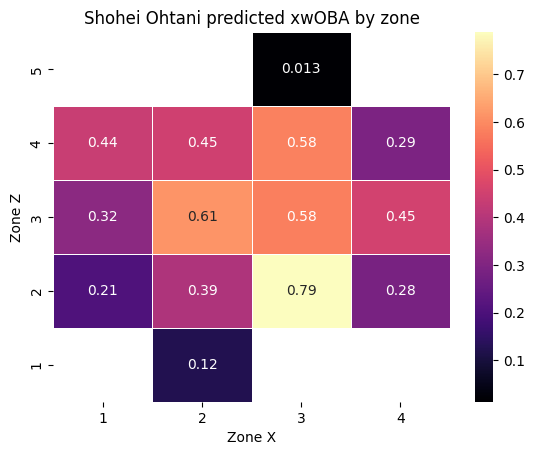

In [14]:
#For an example, here are the xwOBA predictions by zone for Shohei Ohtani given his launch angle and exit velocity data

ohtani_data = pitch_data[pitch_data["batter"] == 660271]
pivot_table = ohtani_data.pivot_table(
    values="estimated_woba_using_speedangle_zone_avg",
    index="zone_z",
    columns="zone_x",
    aggfunc="mean")

sns.heatmap(pivot_table, annot=True, cbar=True, cmap="magma", linewidths=0.5)
plt.xlabel("Zone X")
plt.ylabel("Zone Z")
plt.title("Shohei Ohtani predicted xwOBA by zone")
plt.gca().invert_yaxis()  
plt.show()

In [7]:
pitch_data_bip = pitch_data[pitch_data["description"] == "hit_into_play"]

features = ['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'spin_axis',
            'release_extension', 'estimated_woba_using_speedangle_zone_avg', 'cluster_label', 'n_thruorder_pitcher']

target = 'estimated_woba_using_speedangle'
pitch_data_clean = pitch_data_bip.dropna(subset=[target])
pitch_data_encoded = pd.get_dummies(pitch_data_clean, columns=['pitch_type'])
features = [col for col in features if col in pitch_data_encoded.columns]

X_train, X_test, y_train, y_test = train_test_split(pitch_data_encoded[features], 
                                                    pitch_data_encoded[target], test_size=0.2, random_state=4400)

xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=4400)

param_grid = {'max_depth': [2, 4, 6, 8],
              'learning_rate': [0.05, 0.1, 0.2],
              'n_estimators': [100, 200, 300],
              'subsample': [0.85, 0.9, 0.95],
              'colsample_bytree': [0.6, 0.7, 0.8],
              'reg_lambda': [0.1, 1, 10],          
              'reg_alpha': [0.1, 1, 10]}

grid_search = GridSearchCV(xgb_regressor, param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"Best XGBoost Params: {best_params}")
print(f"XGBoost RMSE: {rmse}")

Fitting 3 folds for each of 2916 candidates, totalling 8748 fits
Best XGBoost Params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300, 'reg_alpha': 10, 'reg_lambda': 10, 'subsample': 0.95}
XGBoost RMSE: 0.36871764957701286


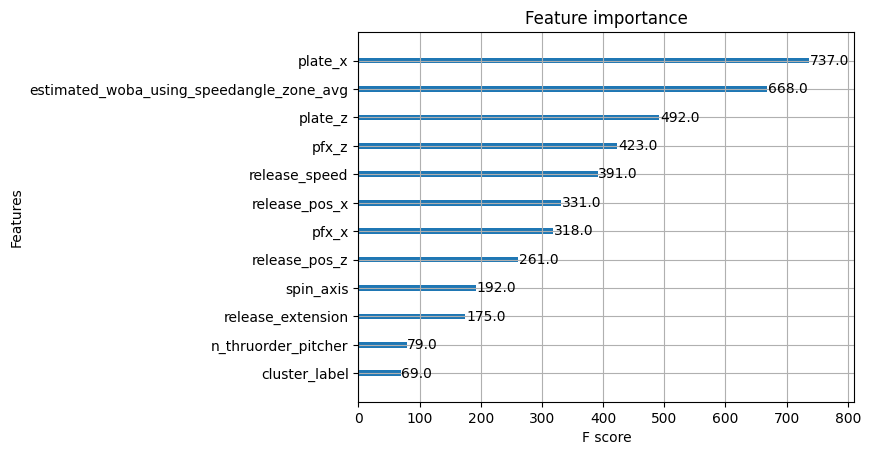

In [8]:
xgb.plot_importance(best_model, importance_type='weight', max_num_features=12)
plt.show()